In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from tqdm.notebook import tqdm
import torch

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy, UnwhitenedVariationalStrategy

from pymc3.gp.util import plot_gp_dist

In [42]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [43]:
# Set seed
np.random.seed(123)

# Generate data

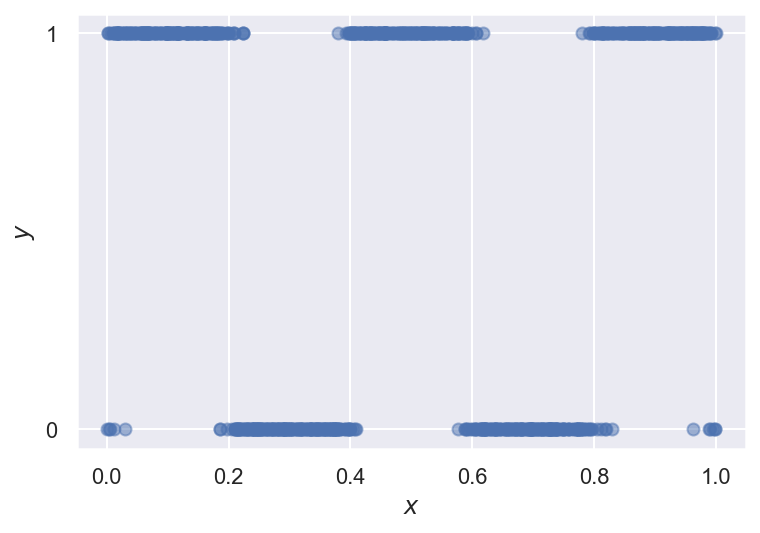

In [44]:
np.random.seed(0)

def true_f(x):
    return np.sin(10*x * np.pi * 0.5) * 10

n = 1000
x = np.sort(np.random.uniform(0, 1, n))
f = true_f(x)
y = scipy.stats.bernoulli.rvs(scipy.special.expit(f))

plt.scatter(x, y, alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.yticks([0, 1]);

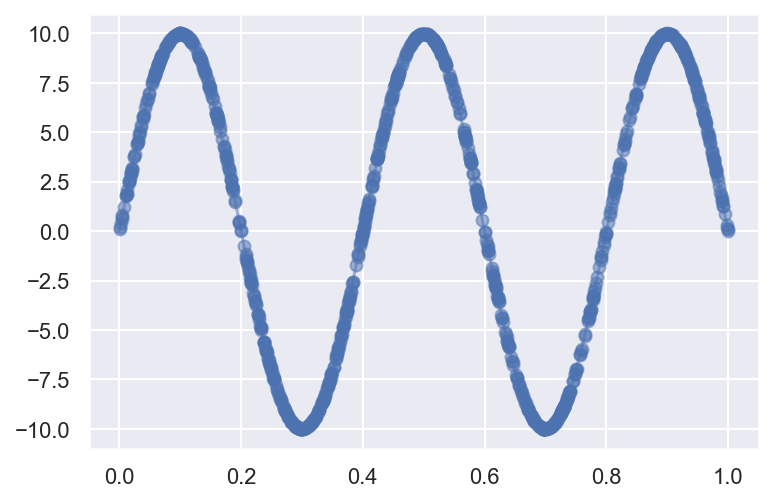

In [45]:
fig, ax = plt.subplots()
x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, true_f(x_plot), alpha=0.5)
ax.scatter(x, f, alpha=0.5);

In [46]:
train_x = torch.from_numpy(x.astype(np.float32))
train_y = torch.from_numpy(y.astype(np.float32))
print(train_x.dtype)
print(train_y.dtype)

torch.float32
torch.float32


In [47]:
inducing_points = torch.rand(50)

In [48]:
inducing_points.shape

torch.Size([50])

In [49]:
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood
from gpytorch.functions import log_normal_cdf


class CustomBernoulliLikelihood(_OneDimensionalLikelihood):
    r"""
    Implements the Bernoulli likelihood used for GP classification, using
    Probit regression (i.e., the latent function is warped to be in [0,1]
    using the standard Normal CDF :math:`\Phi(x)`). Given the identity
    :math:`\Phi(-x) = 1-\Phi(x)`, we can write the likelihood compactly as:
    .. math::
        \begin{equation*}
            p(Y=y|f)=\Phi(yf)
        \end{equation*}
    """

    def forward(self, function_samples, **kwargs):
        raise NotImplementedError

    def log_marginal(self,  *args, **kwargs):
        raise NotImplementedError

    def marginal(self, function_dist, **kwargs):
        raise NotImplementedError

    def expected_log_prob(self, observations, function_dist, *params, **kwargs):

        if torch.any(observations.eq(-1)):
            # Remove after 1.0
            warnings.warn(
                "BernoulliLikelihood.expected_log_prob expects observations with labels in {0, 1}. "
                "Observations with labels in {-1, 1} are deprecated.",
                DeprecationWarning,
            )
        else:
            observations = observations.mul(2).sub(1)
        # Custom function here so we can use log_normal_cdf rather than Normal.cdf
        # This is going to be less prone to overflow errors
        log_prob_lambda = lambda function_samples: log_normal_cdf(function_samples.mul(observations))
        log_prob = self.quadrature(log_prob_lambda, function_dist)
        return log_prob

In [50]:
class GPClassificationModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        # self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(inducing_points=inducing_points)
likelihood = CustomBernoulliLikelihood()

In [51]:
training_iter = 500


# Find optimal model hyperparameters
# model.train()
# likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())


iterator = tqdm(range(training_iter))

for i in iterator:
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    optimizer.step()
    
    iterator.set_postfix(loss=loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

In [52]:
test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)

In [53]:
pred = f_preds.sample(torch.Size((1000,))).numpy()

In [54]:
pred.shape

(1000, 101)

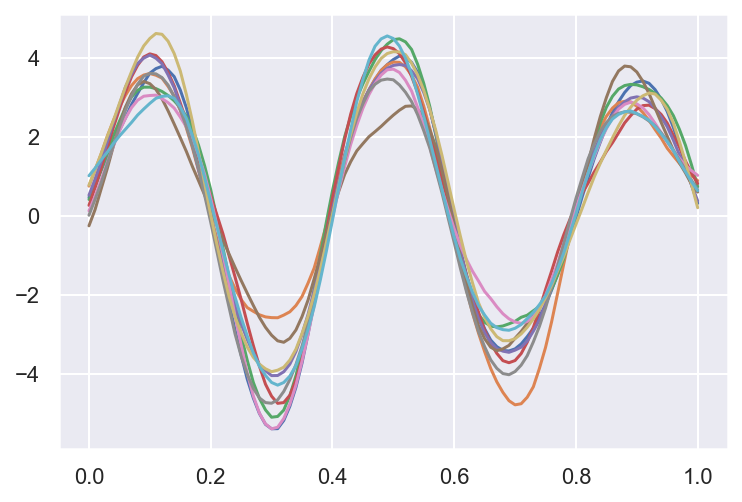

In [55]:
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(test_x, pred[i])

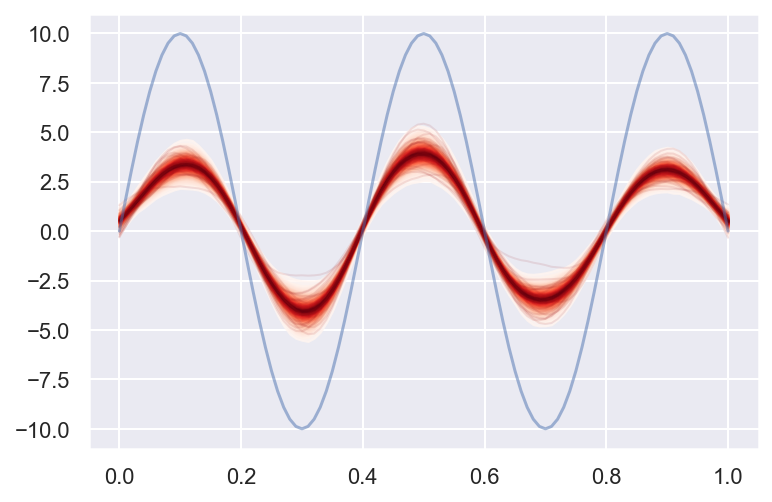

In [56]:
fig, ax = plt.subplots()
plot_gp_dist(ax, pred, test_x)
ax.plot(test_x, true_f(test_x), alpha=0.5)

# Using sklearn

In [20]:
from scipy.special import expit
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

# Generate data

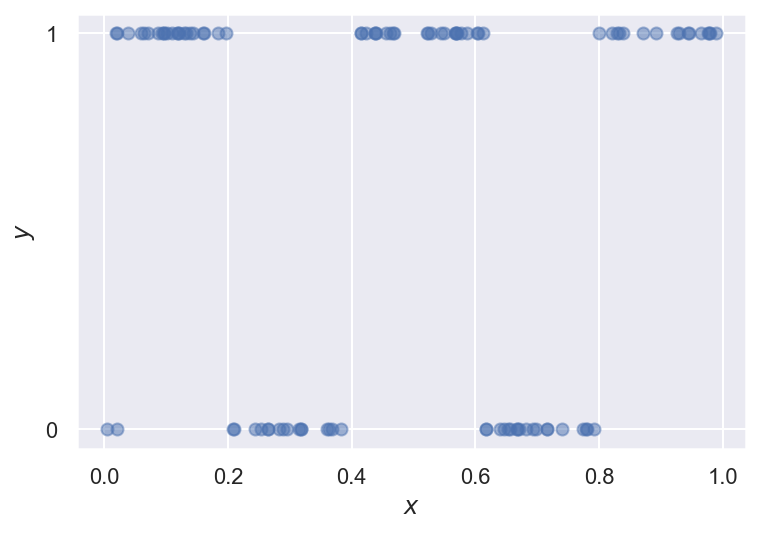

In [24]:
np.random.seed(0)

def true_f(x):
    return np.sin(10*x * np.pi * 0.5) * 10

n = 100
x = np.sort(np.random.uniform(0, 1, n))
f = true_f(x)
y = scipy.stats.bernoulli.rvs(scipy.special.expit(f))

plt.scatter(x, y, alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.yticks([0, 1]);

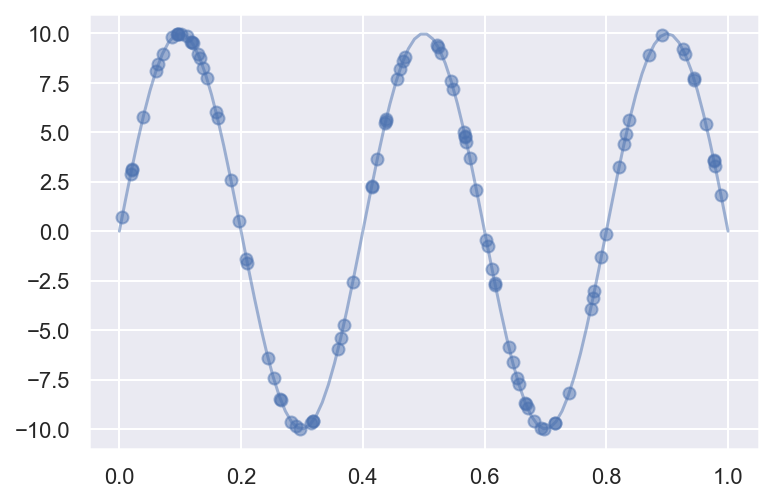

In [25]:
fig, ax = plt.subplots()
x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, true_f(x_plot), alpha=0.5)
ax.scatter(x, f, alpha=0.5);

In [28]:
train_x = x.reshape(-1, 1)
train_y = y.astype(float)
print(train_x.dtype)
print(train_y.dtype)

float64
float64


In [29]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))

# Instantiate a Gaussian Process model
gp = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
fit = gp.fit(train_x, train_y)

/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [35]:
x_plot = np.linspace(0, 1, 1000).reshape(-1, 1)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred = gp.predict(x_plot)

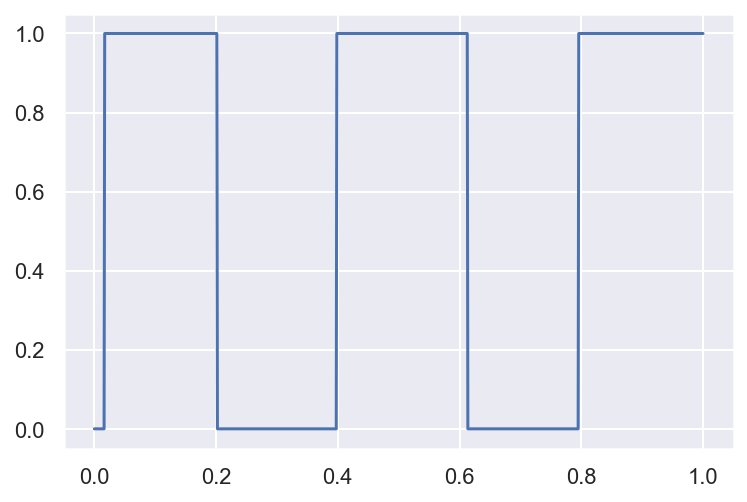

In [36]:
plt.plot(x_plot, y_pred)

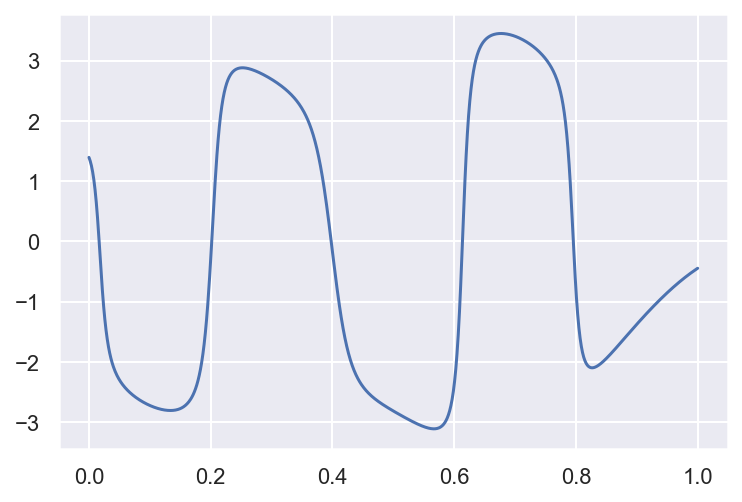

In [40]:

# Create "samples of functions"
f_pred  = scipy.special.logit(gp.predict_proba(x_plot))
plt.plot(x_plot, f_pred[:, 0])